In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.nonparametric import smoothers_lowess as lowess

from core import prices as pr

## Variation du $\alpha$:

Je trouve les résultats assez aléatoires

Intuition : 

In [3]:
# Path to the pickle file
pickle_file_path = '/Volumes/OS-Data/Suzie_data/RLandPricing/data/data_alpha.pkl'

# Open the file in binary read mode
with open(pickle_file_path, 'rb') as file:
    aggregated_agents = pickle.load(file)

# Now, "aggregated_agents" contains the object saved in the pickle file
print(aggregated_agents)

[array([[[0.39084318, 0.25377885],
        [0.39706165, 0.23291286],
        [0.33596733, 0.33596733],
        ...,
        [0.36248322, 0.29202387],
        [0.29871647, 0.27166108],
        [0.27960543, 0.34355771]],

       [[0.11568391, 0.38937236],
        [0.41151884, 0.17764994],
        [0.26545967, 0.26545967],
        ...,
        [0.21612698, 0.4126143 ],
        [0.1559866 , 0.38529321],
        [0.22006659, 0.28502892]],

       [[0.40482139, 0.2584556 ],
        [0.34355771, 0.27960543],
        [0.38740429, 0.2774723 ],
        ...,
        [0.3010206 , 0.33414345],
        [0.3221293 , 0.3221293 ],
        [0.40422786, 0.13026227]],

       ...,

       [[0.38132184, 0.18813575],
        [0.2774723 , 0.38740429],
        [0.2584556 , 0.40482139],
        ...,
        [0.30349388, 0.30349388],
        [0.38740429, 0.2774723 ],
        [0.23089762, 0.30318062]],

       [[0.1964421 , 0.24589853],
        [0.29256439, 0.32384622],
        [0.27129972, 0.33137851],
        

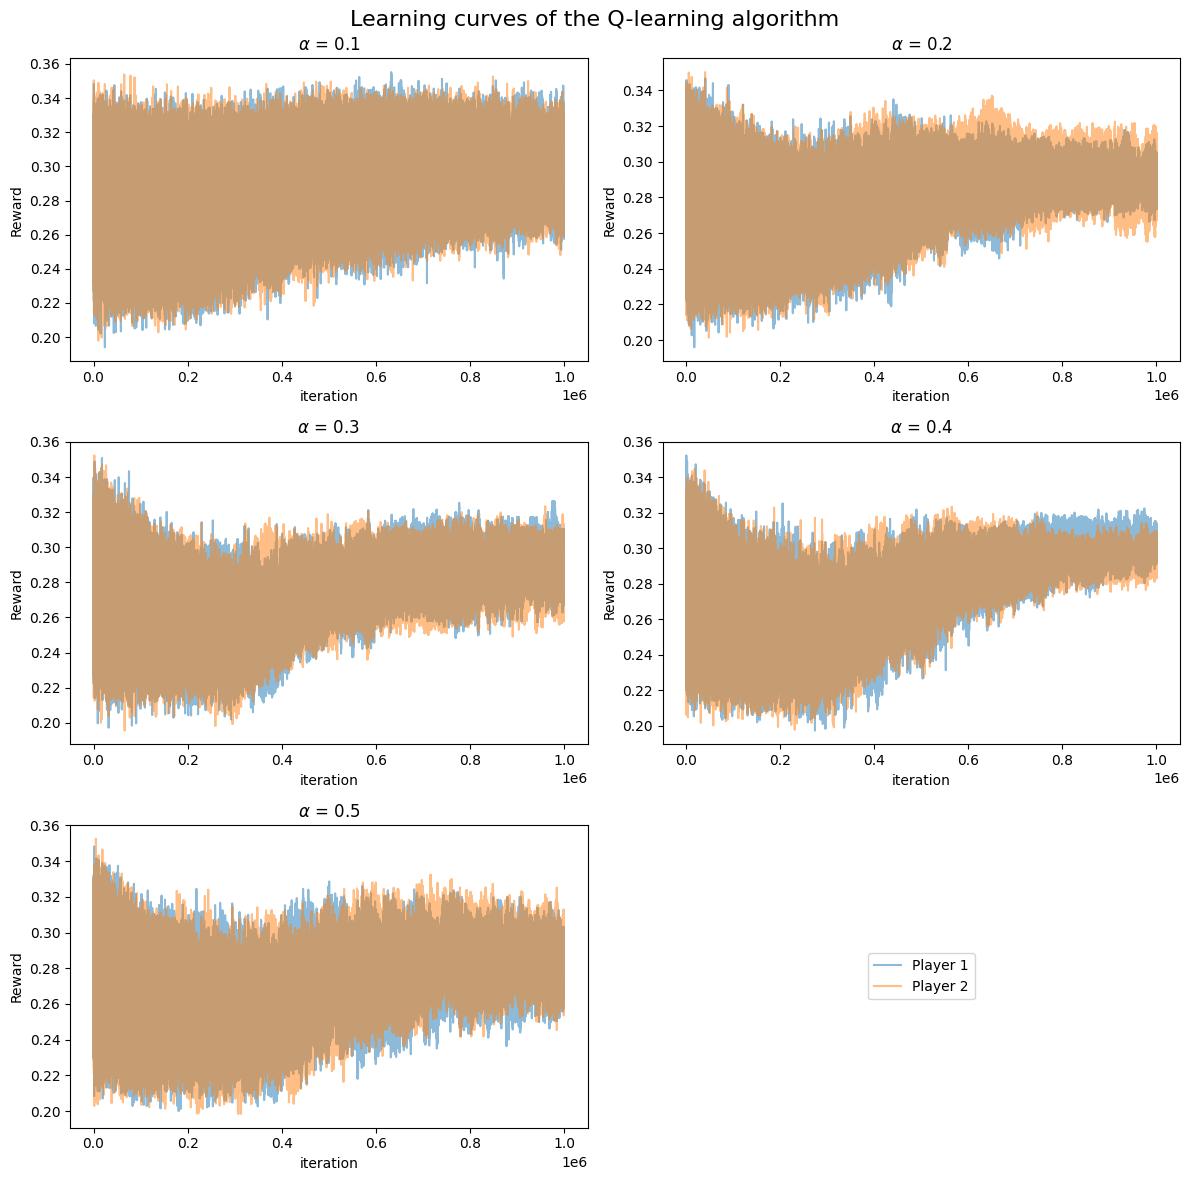

In [4]:
agg = np.array(aggregated_agents).mean(axis=1)
num_players = 2
num_graphs = len(agg)
alpha = [0.1, 0.2, 0.3, 0.4, 0.5]

# Create a figure with a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Loop to iterate through the periods and subplots
for graph_num in range(num_graphs):
    ax = axes[graph_num]
    num_players = len(agg[graph_num][0])
    # Plot curves for each player in the subplot
    for player in range(num_players):
        ax.plot(agg[graph_num][:, player], alpha=0.5, label=f'Player {player + 1}')
    
    # Set the title of the subplot with the corresponding period
    ax.set_title(f'$\\alpha$ = {alpha[graph_num]}')
    
    # Set the labels of the subplot
    ax.set_xlabel('iteration')
    ax.set_ylabel('Reward')


# Remove any unused subplots
if num_graphs < 5:
    for i in range(num_graphs, 5):
        fig.delaxes(axes[i])

# Create a legend in the last subplot
legend_ax = axes[-1]
legend_ax.axis('off')

# Get the legend handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()

# Create the legend in the last subplot
legend_ax.legend(handles, labels, loc='center')

fig.suptitle('Learning curves of the Q-learning algorithm', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

La régression LOESS est particulièrement adaptée quand:
- Les valeurs des prédicteurs X sont discrètes ou peu denses mais la relation avec Y est lisse/continue
- Il y a de la variabilité locale dans les valeurs de Y pour un même X

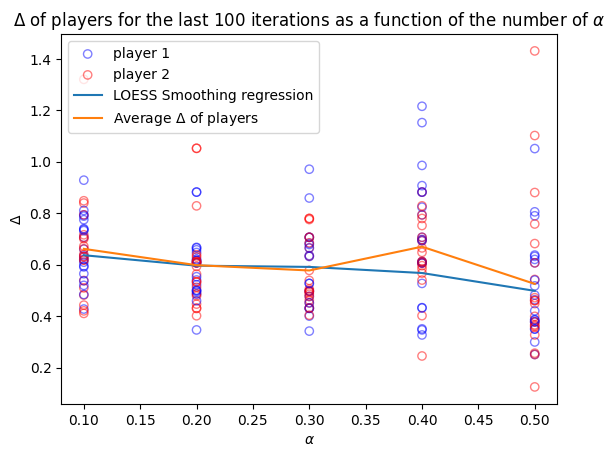

In [5]:
agg = np.array(aggregated_agents).mean(axis=1)
alpha = [0.1, 0.2, 0.3, 0.4, 0.5]
prices = pr.PriceOptimizer()
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()
RN = nash_profit
RC = collusion_profit

    
Rmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0])))
DRmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0]))) 

agg_Rmean = np.zeros((len(aggregated_agents), 2))
agg_DRmean = np.zeros((len(aggregated_agents), 2))  

# Parameters
n_params = len(aggregated_agents)

X = []
Y = []

handles = []
labels = []
# Loop through each parameter  
for param_ind in range(n_params):

  # Loop through each sample
  for sample_ind in range(len(aggregated_agents[0])):
    for j in range (2):
      Rmean[param_ind][sample_ind][j] = aggregated_agents[param_ind][sample_ind][-100:,j].mean()
      DRmean[param_ind][sample_ind][j] = (Rmean[param_ind][sample_ind][j] - RN)/(RC - RN) 
      agg_Rmean[param_ind][j] = agg[param_ind][-100:,j].mean()
      agg_DRmean[param_ind][j] = (agg_Rmean[param_ind][j] - RN)/(RC - RN) 
    
   
    # Plot the point
    h1 = plt.scatter(alpha[param_ind], DRmean[param_ind][sample_ind][0], marker='o', 
                     facecolor='none', edgecolor='b', alpha=0.5, label='player1')
    if param_ind==0 and sample_ind == 0:
      handles.append(h1)
      labels.append('player 1')
    
    h2 = plt.scatter(alpha[param_ind], DRmean[param_ind][sample_ind][1],
                marker='o', facecolor='none', edgecolor='r', alpha=0.5, label='player2')
    if param_ind==0 and sample_ind == 0:
      handles.append(h2)
      labels.append('player 2')
    
    X.append(alpha[param_ind])
    X.append(alpha[param_ind])
    Y.append(DRmean[param_ind][sample_ind][0])
    Y.append(DRmean[param_ind][sample_ind][1])
    

  # End of sample loop
reg = lowess.lowess(Y, X)[:,1]
h3 = plt.plot(X,reg, label = 'LOESS Smoothing regression')
handles.append(h3) 
labels.append('LOESS Smoothing regression')

av = np.mean(agg_DRmean, axis=1)
h4 = plt.plot(alpha,av, label='Average $\\Delta$ of players')
handles.append(h4) 
labels.append('Average $\\Delta$ of players')

plt.xlabel('$\\alpha$')
plt.ylabel('$\\Delta$')
plt.title('$\\Delta$ of players for the last 100 iterations as a function of the number of $\\alpha$')

handles = [handle[0] if type(handle)==list else handle for handle in handles]#in each list take all elements
labels = [label[0] if type(label)==list else label for label in labels]

plt.legend(handles, labels)
plt.show()

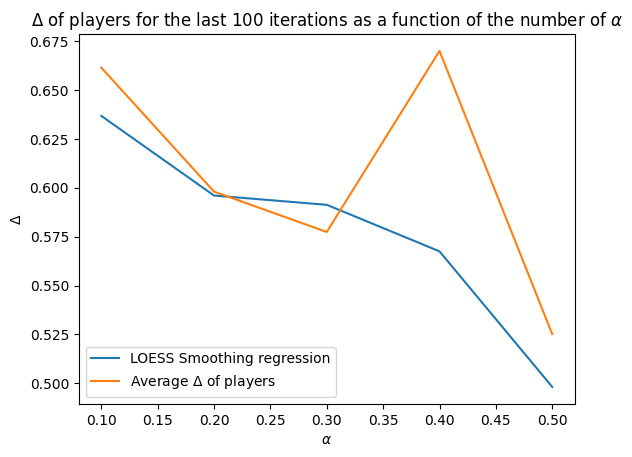

In [6]:
agg = np.array(aggregated_agents).mean(axis=1)
alpha = [0.1, 0.2, 0.3, 0.4, 0.5]
prices = pr.PriceOptimizer()
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()
RN = nash_profit
RC = collusion_profit

    
Rmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0])))
DRmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0]))) 

agg_Rmean = np.zeros((len(aggregated_agents), 2))
agg_DRmean = np.zeros((len(aggregated_agents), 2))  

# Parameters
n_params = len(aggregated_agents)

X = []
Y = []

handles = []
labels = []
# Loop through each parameter  
for param_ind in range(n_params):

  # Loop through each sample
  for sample_ind in range(len(aggregated_agents[0])):
    for j in range (2):
      Rmean[param_ind][sample_ind][j] = aggregated_agents[param_ind][sample_ind][-100:,j].mean()
      DRmean[param_ind][sample_ind][j] = (Rmean[param_ind][sample_ind][j] - RN)/(RC - RN) 
      agg_Rmean[param_ind][j] = agg[param_ind][-100:,j].mean()
      agg_DRmean[param_ind][j] = (agg_Rmean[param_ind][j] - RN)/(RC - RN) 
    
   
    # # Plot the point
    # h1 = plt.scatter(alpha[param_ind], DRmean[param_ind][sample_ind][0], marker='o', 
    #                  facecolor='none', edgecolor='b', alpha=0.5, label='player1')
    # if param_ind==0 and sample_ind == 0:
    #   handles.append(h1)
    #   labels.append('player 1')
    
    # h2 = plt.scatter(alpha[param_ind], DRmean[param_ind][sample_ind][1],
    #             marker='o', facecolor='none', edgecolor='r', alpha=0.5, label='player2')
    # if param_ind==0 and sample_ind == 0:
    #   handles.append(h2)
    #   labels.append('player 2')
    
    X.append(alpha[param_ind])
    X.append(alpha[param_ind])
    Y.append(DRmean[param_ind][sample_ind][0])
    Y.append(DRmean[param_ind][sample_ind][1])
    

  # End of sample loop
reg = lowess.lowess(Y, X)[:,1]
h3 = plt.plot(X,reg, label = 'LOESS Smoothing regression')
handles.append(h3) 
labels.append('LOESS Smoothing regression')

av = np.mean(agg_DRmean, axis=1)
h4 = plt.plot(alpha,av, label='Average $\\Delta$ of players')
handles.append(h4) 
labels.append('Average $\\Delta$ of players')

plt.xlabel('$\\alpha$')
plt.ylabel('$\\Delta$')
plt.title('$\\Delta$ of players for the last 100 iterations as a function of the number of $\\alpha$')

handles = [handle[0] if type(handle)==list else handle for handle in handles]#in each list take all elements
labels = [label[0] if type(label)==list else label for label in labels]

plt.legend(handles, labels)
plt.show()